# ENC 2020
## Turorial: 
## Análisis, Modelado y Predicción de Series de Tiempo
### Juan J. Flores y Héctor Rodríguez
### Agosto de 2020

# Importar bibliotecas

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import seaborn as sns
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error, median_absolute_error 
from sklearn.metrics import mean_squared_log_error

# Importar Datos
- Conjunto de Datos: Producción Mensual de Leche

In [2]:
df = pd.read_csv('./DataSets/monthly-milk-production.csv', 
                 sep=',', parse_dates=['Fecha'], index_col='Fecha')

# Inspección de Datos

- Forma de los Datos

In [3]:
df.shape

(168, 1)

- Primeros registros

In [4]:
df.head()

,Produccion
Fecha,
1962-01-01,589.0
1962-02-01,561.0
1962-03-01,640.0
1962-04-01,656.0
1962-05-01,727.0


- Estadística Básica de los Datos

In [5]:
df.describe()

,Produccion
count,168.000000
mean,754.708333
std,102.204524
min,553.000000
25%,677.750000
50%,761.000000
75%,824.500000
max,969.000000


- Gráfica Conectada

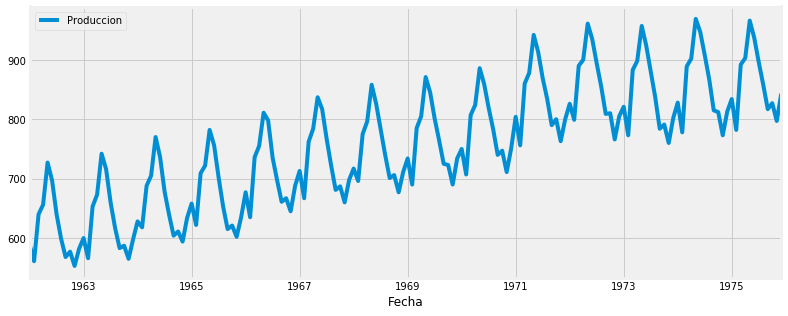

In [6]:
df.plot(figsize=(12,5))
plt.show();

- ST y su Histograma

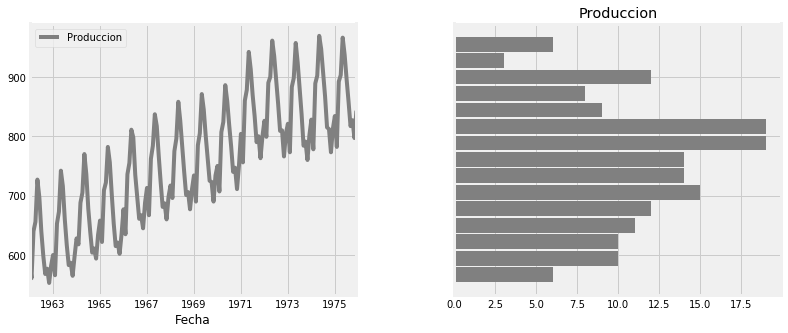

In [7]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, 
                               sharex=False, sharey=True, figsize=(12,5))
df.plot(ax=ax1, color='Gray')
df.hist(ax=ax2, bins=15, xrot=0, yrot=0,
        color='Gray', zorder=2, rwidth=0.9, orientation=u'horizontal')

plt.show();

## Decomposición de la ST

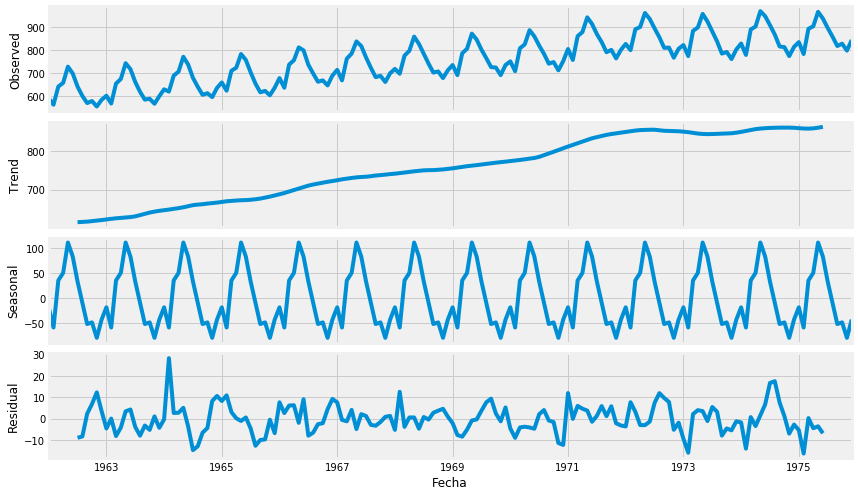

In [8]:
decomposition = seasonal_decompose(df['Produccion'], freq=12, 
                                   model='additive')
plt.rcParams['figure.figsize'] = 12, 7
decomposition.plot()
plt.show();

## Componentes Estacionales
- Separación de los datos por año

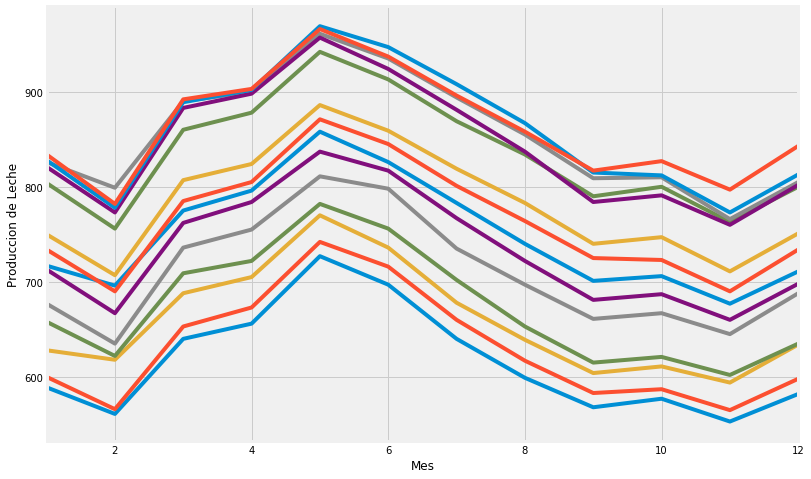

In [9]:
df['anio'] = df.index.year
df['mes'] = df.index.month
df_pivot = pd.pivot_table(df, values='Produccion', index='mes', 
                          columns='anio', aggfunc='mean')
df_pivot.plot(figsize=(12,8))
plt.legend().remove()
plt.xlabel('Mes')
plt.ylabel('Produccion de Leche')
plt.show()

In [10]:
df.drop(['anio', 'mes'], axis=1, inplace=True)

# Identificación del Modelo
__Verificación de Estacionareidad__

## Gráficas ACF y PACF

__Gráficas ACF y PACF: Cuando la ST es estacionaria, las Gráficas ACF y PACF muestran un descenso muy rápido y se extinguen después de un número corto de retardos.__

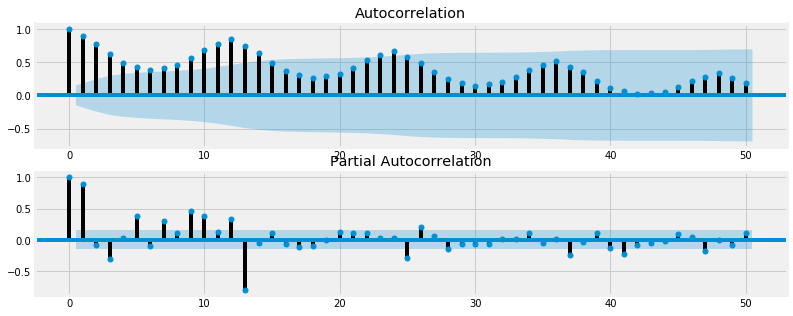

In [11]:
AcPac, (ac, pac) = plt.subplots(nrows=2, ncols=1, 
                               sharex=False, sharey=False, figsize=(12,5))
plot_acf(df, lags=50, ax=ac)
plot_pacf(df, lags=50, ax=pac)
AcPac.show()

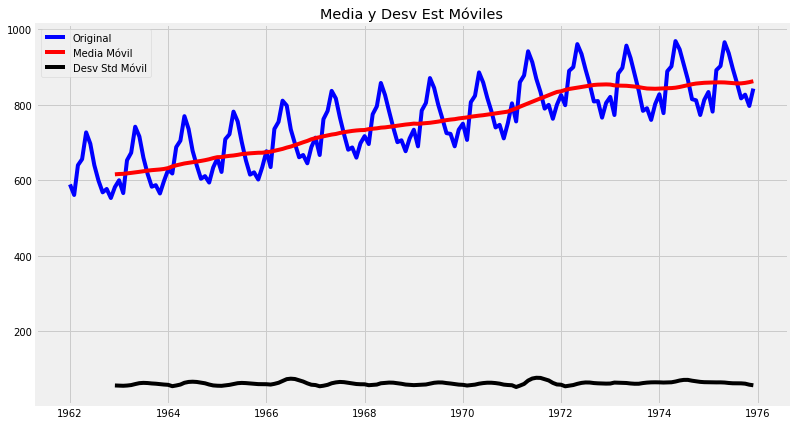

In [12]:
# Estadísticas móviles
rolmean = pd.Series(df['Produccion']).rolling(window=12).mean()
rolstd = pd.Series(df['Produccion']).rolling(window=12).std()

# Y sus gráficas
orig = plt.plot(df['Produccion'], color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Media Móvil')
std = plt.plot(rolstd, color='black', label = 'Desv Std Móvil')
plt.legend(loc='best')
plt.title('Media y Desv Est Móviles')
plt.show(block=False)

## Pruebas Estadísticas de Estacionareidad

__Prueba de Dickey Fuller Aumentada o Prueba de Raíz Unitaria (Unit Root Test)__

Hipótesis nula (H0): la ST es no estacionaria.

Si el valor p (p-value) es menor que el umbral (el nivel de significancia de la prueba, generalmente 5% or 1%) se rechaza la hipótesis nula.

Si el valor p (p-value) es mayor que el umbral no podemos rechazar la hipótesis nula y se sospecha que la ST tiene un componente temporal.

In [13]:
print ('Resultados de la prueba Dickey-Fuller:')
dftest = adfuller(df['Produccion'])

dfoutput = pd.Series(dftest[0:4], 
                     index=['Est. de Prueba',
                            'p-value',
                            '#Lags usados',
                            'No. de obs. usadas'])
for key, value in dftest[4].items():
    dfoutput['Valor Crítico (%s)'%key] = value
print(dfoutput)

Resultados de la prueba Dickey-Fuller:
Est. de Prueba          -1.303812
p-value                  0.627427
#Lags usados            13.000000
No. de obs. usadas     154.000000
Valor Crítico (1%)      -3.473543
Valor Crítico (5%)      -2.880498
Valor Crítico (10%)     -2.576878
dtype: float64


## Estationarización de la ST
__Se realiza por medio de diferencias (una versión discretizada de la derivada).__

- Primero se calcula la diferencia y(t) - y(t-1)
- Posteriormente se calcula la diferencia y(t) - y(t-12)
- Es de nuestro conocimiento que la ST tiene estacionalidad anual
- Se eliminan los datos faltantes

In [14]:
df_diff = (df.diff()).diff(12)

In [15]:
df_diff.dropna(inplace=True)

In [16]:
print ('Resultados de la prueba Dickey-Fuller:')
dftest = adfuller(df_diff['Produccion'])

dfoutput = pd.Series(dftest[0:4], index=['Est. de Prueba',
                            'p-value',
                            '#Lags usados',
                            'No. de obs. usadas'])
for key, value in dftest[4].items():
    dfoutput['Valor Crítico (%s)'%key] = value
print(dfoutput)

Resultados de la prueba Dickey-Fuller:
Est. de Prueba          -5.038002
p-value                  0.000019
#Lags usados            11.000000
No. de obs. usadas     143.000000
Valor Crítico (1%)      -3.476927
Valor Crítico (5%)      -2.881973
Valor Crítico (10%)     -2.577665
dtype: float64


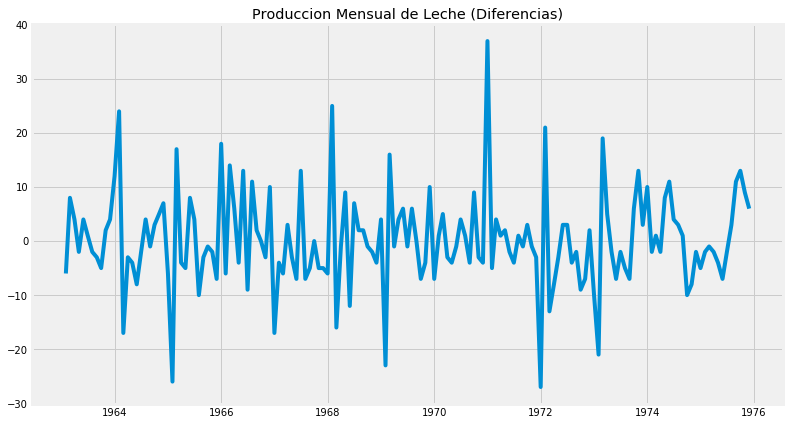

In [17]:
plt.plot(df_diff['Produccion'])
plt.title('Produccion Mensual de Leche (Diferencias)')
plt.savefig('diffplot')
plt.show()

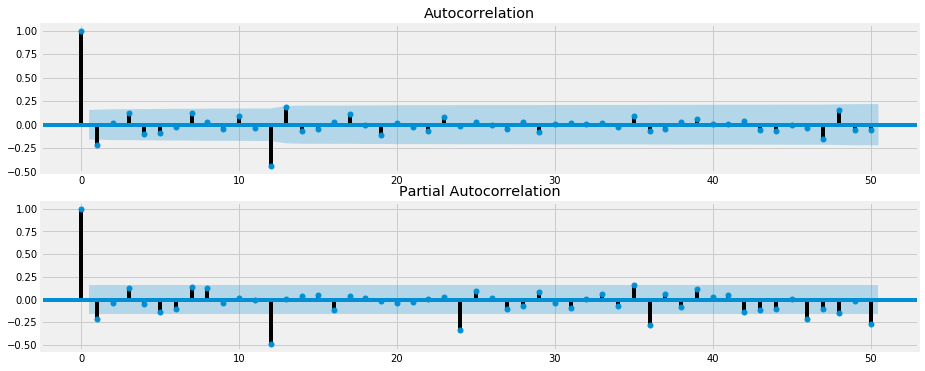

In [18]:
diffAC, (dac, dpac) = plt.subplots(nrows=2, ncols=1, figsize=(14,6), 
                                   sharex=False, sharey=False)
ax1 = plot_acf(df_diff, lags=50, ax=dac)
ax2 = plot_pacf(df_diff, lags=50, ax=dpac)
plt.savefig('acfpacf2')
plt.show()

# Model Parameter Estimation

In [19]:
import pmdarima as pm
model = pm.auto_arima(df['Produccion'], d=1, D=1,
                      seasonal=True, m=12, trend='c', 
                      start_p=0, start_q=0, max_order=6, 
                      test='adf', stepwise=True, trace=True)


/Users/juan/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/Users/juan/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 1, 12); AIC=1076.128, BIC=1088.302, Fit time=0.291 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=1121.939, BIC=1128.026, Fit time=0.022 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=1083.569, BIC=1095.742, Fit time=0.349 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1068.286, BIC=1080.460, Fit time=0.356 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=1070.017, BIC=1085.234, Fit time=0.489 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=1116.950, BIC=1126.081, Fit time=0.099 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=1069.963, BIC=1085.180, Fit time=0.822 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=1071.361, BIC=1089.621, Fit time=2.255 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1070.056, BIC=1085.273, Fit time=0.474 seconds
Fit ARIMA: order=(0, 1, 0) s

In [20]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  168
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -530.143
Date:                            Sat, 22 Aug 2020   AIC                           1068.286
Time:                                    15:41:19   BIC                           1080.460
Sample:                                         0   HQIC                          1073.231
                                            - 168                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0205      0.222     -0.092      0.927      -0.457       0.416
ma.L1         -0.2206      0.079     -2.809      0.005      -0.374      -0.067
ma.S.L12      -0.6218      0.071     -8.757      0.000      -0.761      -0.483
sigma2        52.6972      5.155     10.223      0.000      42.594      62.801
===================================================================================
Ljung-Box (Q):                       21.34   Jarque-Bera (JB):                33.63
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.83   Skew:                             0.74
Prob(H) (two-sided):                  0.50   Kurtosis:                         4.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

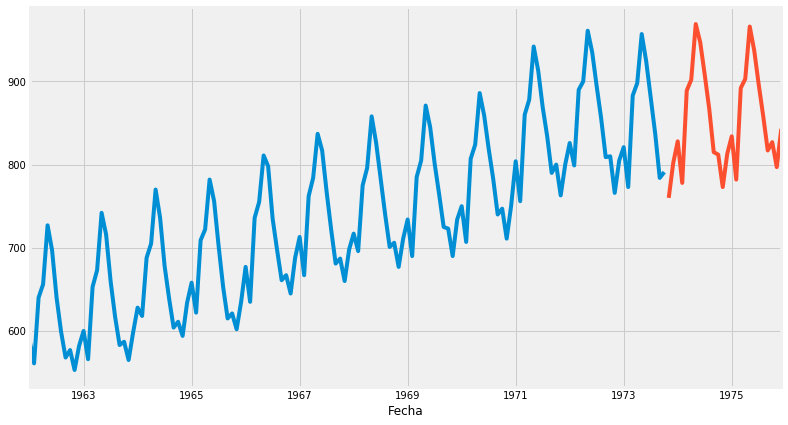

In [21]:
# Dividir datos en Conjuntos de Entrenamiento y Prueba
train = df[:int(0.85*(len(df)))]
test = df[int(0.85*(len(df))):]

# Gráficas de los conjuntos
train['Produccion'].plot()
test['Produccion'].plot()

In [22]:
model = SARIMAX(train['Produccion'],order=(1,1,0),
                seasonal_order=(0,1,1,12),freq="MS")
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                         Produccion   No. Observations:                  142
Model:             SARIMAX(1, 1, 0)x(0, 1, 1, 12)   Log Likelihood                -445.603
Date:                            Sat, 22 Aug 2020   AIC                            897.205
Time:                                    15:41:19   BIC                            905.785
Sample:                                01-01-1962   HQIC                           900.691
                                     - 10-01-1973                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2728      0.087     -3.149      0.002      -0.443      -0.103
ma.S.L12      -0.6158      0.086     -7.163      0.000      -0.784      -0.447
sigma2        56.0243      5.765      9.719      0.000      44.726      67.323
===================================================================================
Ljung-Box (Q):                       24.06   Jarque-Bera (JB):                40.04
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.12   Skew:                             0.86
Prob(H) (two-sided):                  0.71   Kurtosis:                         5.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Verificación Estadística del Modelo

__Diagnóstico del Modelo__

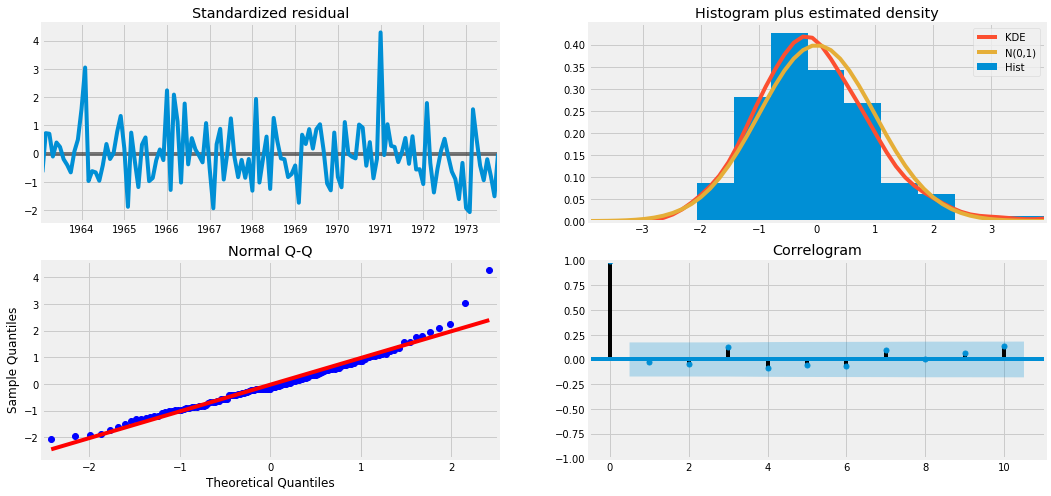

In [23]:
results.plot_diagnostics(figsize=(16, 8))
plt.savefig('modeldiagnostics')
plt.show()

In [24]:
forecast_object = results.get_forecast(steps=len(test))

mean = forecast_object.predicted_mean

conf_int = forecast_object.conf_int()

dates = mean.index

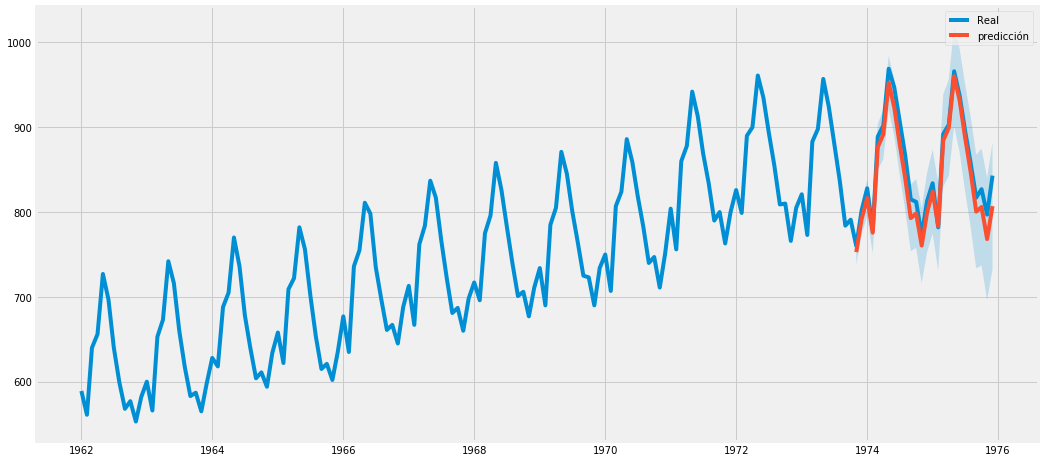

In [25]:
plt.figure(figsize=(16,8))

# Gráfica de producción anterior
plt.plot(df.index, df, label='Real')

# Gráfica de la predicción
plt.plot(dates, mean, label='predicción')

# Sombreado de los intervalos de confianza
plt.fill_between(dates, conf_int.iloc[:,0], conf_int.iloc[:,1],
alpha=0.2)

# Incluir leyenda y Mostrar la gráfica
plt.legend()
plt.savefig('predtest')
plt.show()

In [26]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, 
                              dynamic=False, 
                              typ='levels').rename('SARIMA(1,1,0)(0,1,1,12) Predictions')

In [27]:
# Comparar las predicciones a los valores esperados
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test['Produccion'][i]}")

predicted=752.7789609, expected=760.0
predicted=791.7112656, expected=802.0
predicted=816.6069863, expected=828.0
predicted=775.7138798, expected=778.0
predicted=876.5424637, expected=889.0
predicted=891.6737755, expected=902.0
predicted=952.5816346, expected=969.0
predicted=923.4027757, expected=947.0
predicted=880.2747092, expected=908.0
predicted=839.9639144, expected=867.0
predicted=792.9111367, expected=815.0
predicted=798.3153892, expected=812.0
predicted=760.5296712, expected=773.0
predicted=799.34322  , expected=813.0
predicted=824.2713374, expected=834.0
predicted=783.369393 , expected=782.0
predicted=884.2003879, expected=892.0
predicted=899.331042 , expected=903.0
predicted=960.2390805, expected=966.0
predicted=931.0601727, expected=937.0
predicted=887.9321195, expected=896.0
predicted=847.6213211, expected=858.0
predicted=800.5685443, expected=817.0
predicted=805.9727966, expected=827.0
predicted=768.1870787, expected=797.0
predicted=807.0006274, expected=843.0


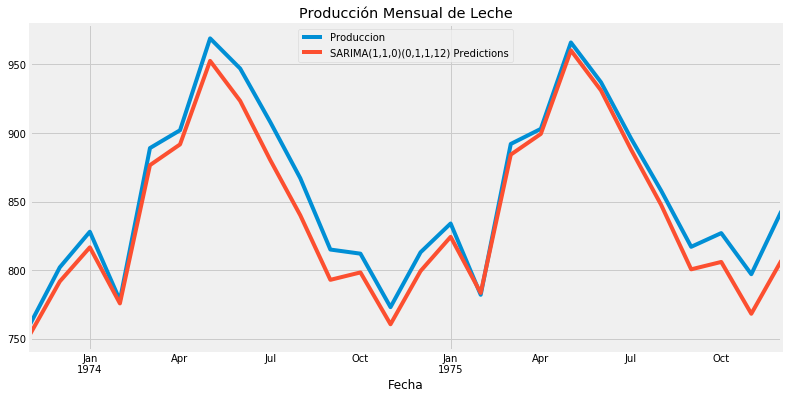

In [28]:
# Gráfica de predicciones vs. valores reales
title = 'Producción Mensual de Leche'
ax = test['Produccion'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
#ax.set(xlabel=xlabel, ylabel=ylabel);

In [29]:
r2_score(test['Produccion'], predictions)

0.9240433738435627

In [30]:
evaluation_results = pd.DataFrame({'r2': r2_score(test['Produccion'], predictions)}, index=[0])
evaluation_results['MAE'] = mean_absolute_error(test['Produccion'], predictions)
evaluation_results['MSE'] = mean_squared_error(test['Produccion'], predictions)
evaluation_results['MAPE'] = np.mean(np.abs(predictions - test['Produccion'])/np.abs(test['Produccion']))*100 

evaluation_results

,r2,MAE,MSE,MAPE
0,0.924043,14.062889,274.940627,1.649905


# Predicciones

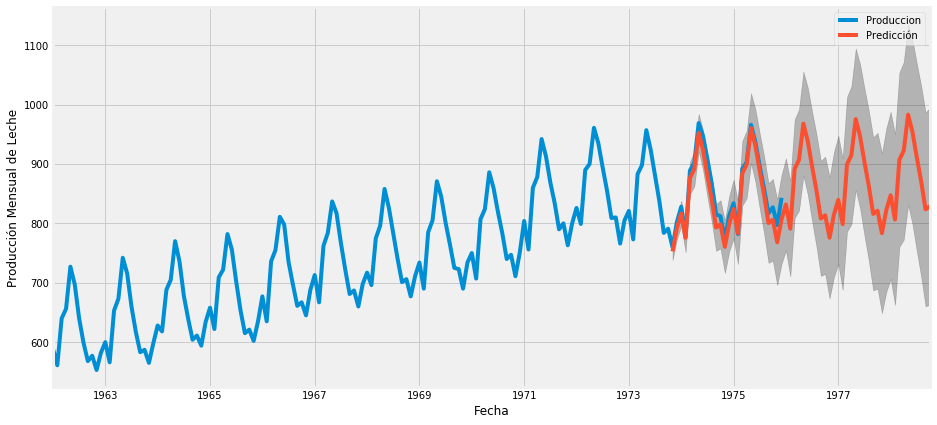

In [31]:
pred_f = results.get_forecast(steps=60)
pred_ci = pred_f.conf_int()
ax = df.plot(label='Produccion', figsize=(14, 7))
pred_f.predicted_mean.plot(ax=ax, label='Predicción')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Fecha')
ax.set_ylabel('Producción Mensual de Leche')
plt.legend()
plt.show()